In [40]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MaxNLocator, LogLocator

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

In [10]:
datasets = ['adult', 'folktables', 'hmda']
dataset_names = {'adult': 'Adult', 'folktables': 'Folktables', 'hmda': 'HMDA'}

model_classes = ['logistic', 'RF', 'nn']
model_class_names = {'logistic': 'Logistic Regression', 'RF': 'Random Forest', 'nn': 'Neural Network'}


In [11]:
def compute_true_cei(df, u, true_u, model_class):
    filtered_rows = df[df[f'{model_class}_eval_SRG'] < u]
    if len(filtered_rows) == 0:
        return 0
    return (true_u - filtered_rows[f'{model_class}_df_SRG'].mean()) * len(filtered_rows) / len(df)



In [86]:
def compute_no_assm_and_true_cei(df, B, T, model_class, i):

    no_assm_df = pd.DataFrame(index=range(B), columns=[f'bound_no_assm_{t}' for t in range(T)])
    true_cei_df = pd.DataFrame(index=range(B), columns=[f'true_cei_{t}' for t in range(T)])


    miscovered = 0
    for b in range(B):
        u_hat_t = 1
        bound_no_assm = []
        true_cei = []

        resampled_df = df.sample(frac=1, replace=True).reset_index(drop=True)
        miscovered_i = False

        # compute UB on the true CEI
        for t in range(T):
            if t == 0:
                p_t = 1 - math.exp(-1/delta)
            else:
                p_t = 1 - (t/delta + 1)**(-1/t)
            i_t = i_t if u_hat_t < resampled_df.loc[t, f"{model_class}_eval_SRG"] else t
            u_hat_t = resampled_df.loc[i_t, f"{model_class}_eval_SRG"]
            u_t = resampled_df.loc[i_t, f"{model_class}_df_SRG"]
            bound_no_assm.append(u_hat_t * p_t)
            true_marginal_gain = compute_true_cei(df, u_hat_t, u_t, model_class)
            true_cei.append(true_marginal_gain)
            if u_hat_t * p_t < true_marginal_gain and not miscovered_i:
                miscovered += 1
                miscovered_i = True
        no_assm_df.loc[b] = bound_no_assm
        true_cei_df.loc[b] = true_cei

    no_assm_means = no_assm_df.mean(axis=0)
    true_cei_means = true_cei_df.mean(axis=0)

    no_assm_sds = no_assm_df.std(axis=0)
    true_cei_sds = true_cei_df.std(axis=0)

    saved_data = {
        "no_assm_means": no_assm_means.to_list(),
        "true_cei_means": true_cei_means.to_list(),
        "no_assm_sds": no_assm_sds.to_list(),
        "true_cei_sds": true_cei_sds.to_list(),
    }
    print(miscovered/B)
    saved_data = pd.DataFrame(saved_data)
    saved_data.to_csv(f'{dataset}_{model_class}_{i}.csv')
        
def compute_mrl_assm_and_true_cei(df, B, T, model_class, i):

    mrl_assm_df = pd.DataFrame(index=range(B), columns=[f'bound_mrl_assm_{t}' for t in range(T)])
    true_cei_df = pd.DataFrame(index=range(B), columns=[f'true_cei_{t}' for t in range(T)])


    T_1 = math.ceil(18 * math.log(3/delta))
    for b in range(B):
        u_hat_t = 1
        bound_mrl_assm = []
        true_cei = []

        resampled_df = df.sample(frac=1, replace=True).reset_index(drop=True)
        quantile_samples = [resampled_df.loc[t, f"{model_class}_eval_SRG"] for t in range(T_1)]
        C = sorted(quantile_samples)[math.floor(T_1/3)]
        S_t = []
        nuhats = []
        lambdas = [1/2]
        mubar_eb = 1
        Deltas = []
        for t in range(T_1, T + T_1):
            if t == T_1:
                p_t = 1 - math.exp(-1/delta)
            else:
                p_t = 1 - ((t - T_1)/delta+ 1)**(-1/(t - T_1))
            i_t = i_t if u_hat_t < resampled_df.loc[t, f"{model_class}_eval_SRG"] else t
            q_hat_t = resampled_df.loc[t, f"{model_class}_eval_SRG"]
            if C - q_hat_t > 0:
                Deltas.append(C - q_hat_t)
                S_t.append(t - T_1)
                nuhats.append((1/2 + sum([Deltas[i] for i,s in enumerate(S_t)])) / (1 + len(S_t)))
            u_hat_t = resampled_df.loc[i_t, f"{model_class}_eval_SRG"]

            if len(S_t) > 1:
                lambdas.append( min(1/2, math.sqrt((2 * math.log(6/delta)) / (sigmasq_hat_tm1 * len(S_t) * math.log(1 + len(S_t))))) )
                mubar_eb_num = (math.log(6/delta) + sum([lambdas[i]*Deltas[i] - (Deltas[i] - (nuhats[i-1] if i > 0 else 1/2))**2 * (math.log(1-lambdas[i]) + lambdas[i]) for i, s in enumerate(S_t)]))
                mubar_eb_denom = (sum([lambdas[i] for i,s in enumerate(S_t)]))
                mubar_eb = mubar_eb_num / mubar_eb_denom

            if len(S_t) > 0:
                sigmasq_hat_tm1 = (1/4 + sum([(Deltas[i] - nuhats[i])**2 for i, s in enumerate(S_t)])) / (1 + len(S_t))


            mu_bar_t = min(u_hat_t, mubar_eb)
            u_t = resampled_df.loc[i_t, f"{model_class}_df_SRG"]
            bound_mrl_assm.append(u_hat_t * p_t)
            true_cei.append(compute_true_cei(df, u_hat_t, u_t, model_class))
        mrl_assm_df.loc[b] = bound_mrl_assm
        true_cei_df.loc[b] = true_cei

    mrl_assm_means = mrl_assm_df.mean(axis=0)
    true_cei_means = true_cei_df.mean(axis=0)

    mrl_assm_sds = mrl_assm_df.std(axis=0)
    true_cei_sds = true_cei_df.std(axis=0)

    saved_data = {
        "mrl_assm_means": mrl_assm_means.to_list(),
        "true_cei_means": true_cei_means.to_list(),
        "mrl_assm_sds": mrl_assm_sds.to_list(),
        "true_cei_sds": true_cei_sds.to_list(),
    }
    saved_data = pd.DataFrame(saved_data)
    saved_data.to_csv(f'{dataset}_{model_class}_mrl_{i}.csv')


In [59]:
def plot_cei_comparison(ax, dataset, model_class, with_mrl_assm, max_num_datasets):

    est_means = np.zeros(T)
    true_cei_means = np.zeros(T)
    est_sds = np.zeros(T)
    true_cei_sds = np.zeros(T)
    hi_est = np.zeros(T)
    lo_est = np.zeros(T)
    hi_true_cei = np.zeros(T)
    lo_true_cei = np.zeros(T)

    for i in range(max_num_datasets):
        derived_data_fname = f'{dataset}_{model_class}_{i}.csv' if not with_mrl_assm else f'{dataset}_{model_class}_mrl_{i}.csv'
        derived_data = pd.read_csv(derived_data_fname)

        est_var_prefix = "no_assm_" if not with_mrl_assm else "mrl_assm_"

        est_means += pd.to_numeric(derived_data[est_var_prefix + 'means'])
        true_cei_means += pd.to_numeric(derived_data['true_cei_means'])
        est_sds += pd.to_numeric(derived_data[est_var_prefix + 'sds'])
        true_cei_sds += pd.to_numeric(derived_data['true_cei_sds'])

    est_means /= max_num_datasets
    true_cei_means /= max_num_datasets
    est_sds /= max_num_datasets
    true_cei_sds /= max_num_datasets

    hi_est = pd.to_numeric(est_means + est_sds)
    lo_est = pd.to_numeric(est_means - est_sds)
    hi_true_cei = pd.to_numeric(true_cei_means + true_cei_sds)
    lo_true_cei = pd.to_numeric(true_cei_means - true_cei_sds)

    sns.lineplot(x=range(1, T+1), y=est_means, label=r'Upper bound ($\bar\mu(\hat U_t) \cdot \bar p_t(\delta)$)', linewidth=2.5, ax=ax, legend=False)
    ax.fill_between(range(1, T+1), lo_est, hi_est, alpha=0.2)
    sns.lineplot(x=range(1, T+1), y=true_cei_means, label=r'Full information ($g(\hat U_t)$)', linewidth=2.5, ax=ax, legend=False)
    ax.fill_between(range(1, T+1), lo_true_cei, hi_true_cei, alpha=0.2)
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[], numticks=5))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ylower = 10e-6
    if dataset in ['adult']:
        ax.set_ylim(ylower, 0.6)
    elif dataset in ['folktables']:
        ax.set_ylim(ylower, 0.6)
    else:
        ax.set_ylim(ylower, 0.6)
    ax.set_xlim(1, T)


def plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=1):
    fig, axes = plt.subplots(3, 3, figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl")

    for j, dataset in enumerate(datasets):
        for i, model_class in enumerate(model_classes):
            plot_cei_comparison(axes[j][i], dataset, model_class, with_mrl_assm, max_num_datasets)

    bigfont = 20
    smallerfont = 17
    fig.supxlabel('Iteration', fontsize=bigfont)
    fig.supylabel('Marginal Gain', fontsize=bigfont)

    for i, model_class in enumerate(model_classes):
        axes[0][i].set_title(model_class_names[model_class], fontsize=smallerfont)

    for i, ds in enumerate(datasets):
        axes[i][0].set_ylabel(dataset_names[ds], fontsize=smallerfont)


    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.53, 1.12), ncol=3, fontsize=bigfont, frameon=True, fancybox=True, shadow=True)

    fig.tight_layout()
    fig_fname_postfix = "" if not with_mrl_assm else "_mrl"
    fig.savefig(f'cei_comparison{fig_fname_postfix}.svg', format='svg', dpi=300, bbox_inches='tight')


In [88]:
delta = 0.05

max_num_datasets = 5
B = 1000
T = 60 # number of model training iterations

for i in range(max_num_datasets):
    print(f"Processing dataset {i+1} of {max_num_datasets}")
    for dataset in datasets:
        for model_class in model_classes:
            print(dataset, model_class)
            results = pd.read_csv(f'results_data/{dataset}_results_{i}.csv')
            compute_no_assm_and_true_cei(results, B, T, model_class, i)
            compute_mrl_assm_and_true_cei(results, B, T, model_class, i)

Processing dataset 1 of 5
adult logistic
0.0
adult RF
0.001
adult nn
0.0
folktables logistic
0.087
folktables RF
0.3
folktables nn
0.004
hmda logistic
0.0
hmda RF
0.0
hmda nn
0.106
Processing dataset 2 of 5
adult logistic
0.0
adult RF
0.0
adult nn
0.0
folktables logistic
0.004
folktables RF
0.094
folktables nn
0.002
hmda logistic
0.0
hmda RF
0.0
hmda nn
0.271
Processing dataset 3 of 5
adult logistic
0.0
adult RF
0.0
adult nn
0.091
folktables logistic
0.089
folktables RF
0.041
folktables nn
0.026
hmda logistic
0.0
hmda RF
0.0
hmda nn
0.174
Processing dataset 4 of 5
adult logistic
0.0
adult RF
0.0
adult nn
0.0
folktables logistic
0.0
folktables RF
0.061
folktables nn
0.001
hmda logistic
0.0
hmda RF
0.0
hmda nn
0.079
Processing dataset 5 of 5
adult logistic
0.0
adult RF
0.0
adult nn
0.0
folktables logistic
0.0
folktables RF
0.0
folktables nn
0.0
hmda logistic
0.0
hmda RF
0.0
hmda nn
0.045


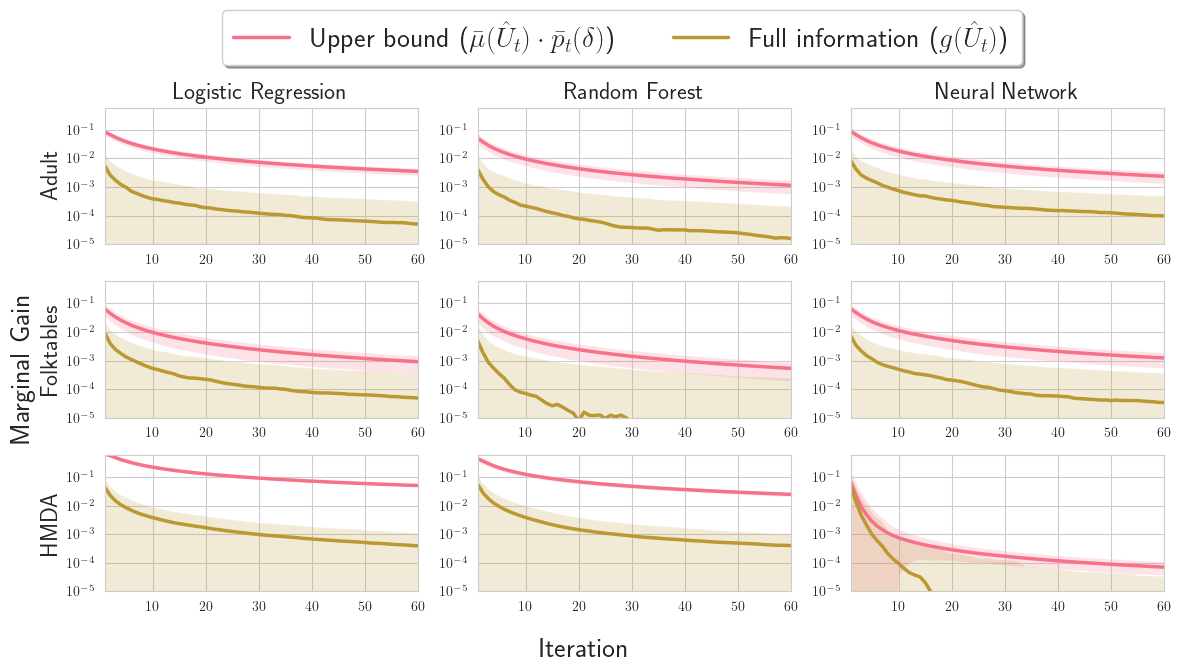

In [66]:
plot_cei_comparison_all(False, max_num_datasets)

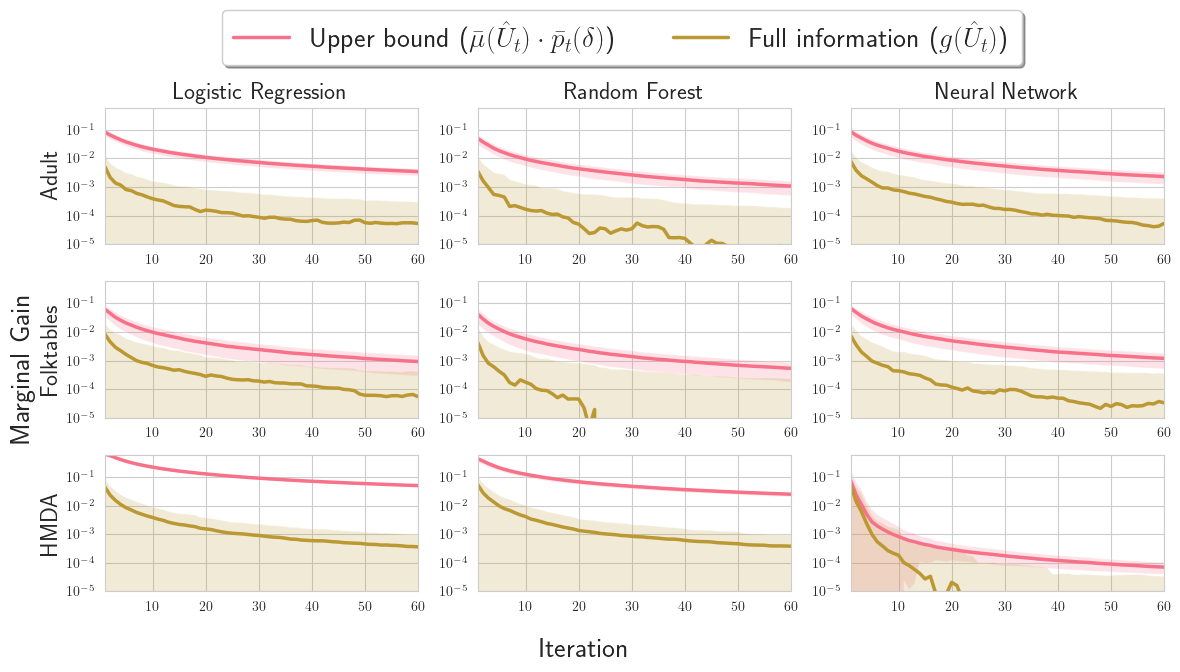

In [62]:
plot_cei_comparison_all(True, max_num_datasets)

In [80]:
dataset = 'adult'
model_class = 'logistic'

srg_rows = []
accuracy_rows = []
for dataset in datasets:
    results = pd.read_csv(f'results_data/{dataset}_results_{i}.csv')

    srg_means = [np.mean(results[f"{model_class}_df_SRG"]) for model_class in model_classes]
    srg_stds = [np.std(results[f"{model_class}_df_SRG"]) for model_class in model_classes]
    accuracy_means = [np.mean(results[f"{model_class}_df_accuracy"]) for model_class in model_classes]
    accuracy_stds = [np.std(results[f"{model_class}_df_accuracy"]) for model_class in model_classes]
    srg_rows.append(f"{dataset_names[dataset]} & " + " & ".join([f"{srg_means[i]:0.3f} ({srg_stds[i]:0.3f})" for i in range(len(model_classes))]))
    accuracy_rows.append(f"{dataset_names[dataset]} & " + " & ".join([f"{accuracy_means[i]:0.3f} ({accuracy_stds[i]:0.3f})" for i in range(len(model_classes))]))

srg_rows = "\\".join(srg_rows)
accuracy_rows = "\\".join(accuracy_rows)



In [82]:
accuracy_rows

'Adult & 0.824 (0.001) & 0.819 (0.003) & 0.816 (0.003)\\Folktables & 0.777 (0.002) & 0.808 (0.005) & 0.794 (0.004)\\HMDA & 0.594 (0.003) & 0.585 (0.006) & 0.505 (0.062)'